In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy

from pcse.fileinput import CABOFileReader
from pcse.models import Wofost71_PP
from pcse.fileinput import CABOWeatherDataProvider
from pcse.base.parameter_providers import ParameterProvider
from pcse.util import WOFOST71SiteDataProvider
from pcse.fileinput import YAMLAgroManagementReader

%matplotlib inline

In [2]:
from enwofost import enwofost

## First, try making ensembles from just the strings pointing towards the different WOFOST components

In [3]:
# point towards the distribution CSV
distribution_file = 'par_prior.csv'

# the crop parameter file
crop_file = 'data/henan_crop_params.CAB'

# the soil parameter file
soil_file = 'data/Hengshui.soil'

# add a file descriptor to highlight the weather files with wildcards.
# each file describes daily weather stats for one year.
weather_point = 'data/henan_s01*'

# and give the model the timer file which controls the dates for WOFOST
timer_file = 'data/timer.amgt'


ensemble_number = 20

# set it up in potential mode at first - it has all the water it needs
ensembles_1 = enwofost(ensemble_number,'potential')

ensembles_1.Generate_With_Dists_From_Scratch(distribution_file,crop_file,
                                             soil_file,weather_point,timer_file,
                                            central_value='absolute')

In [4]:
# display the results for a few parameters

# define some parameters we want to see
target_parameters = ['LAI', 'TWSO', 'DVS']

# use the method Extract_Params to get a dictionary of outputs
outputs_1 = ensembles_1.Extract_Params(target_parameters)

In [5]:
# using the Extract_Params is a usefull method to put the ensembles into 2d array for each parameter.
# it returns a dictionary with each given key is an output parameters
print (outputs_1.keys())

# each limb of the dictionary is ensemble_number * num_of_days
print (outputs_1[target_parameters[0]].shape)
print ('Dim 1 = %s ensemble runs, Dim 2 = %s number of days'%(ensemble_number,outputs_1[target_parameters[0]][0].shape))

dict_keys(['LAI', 'TWSO', 'DVS'])
(20, 273)
Dim 1 = 20 ensemble runs, Dim 2 = (273,) number of days


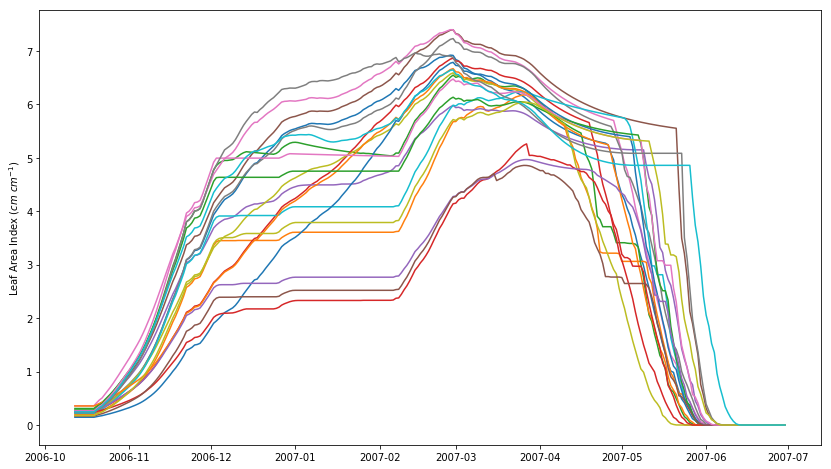

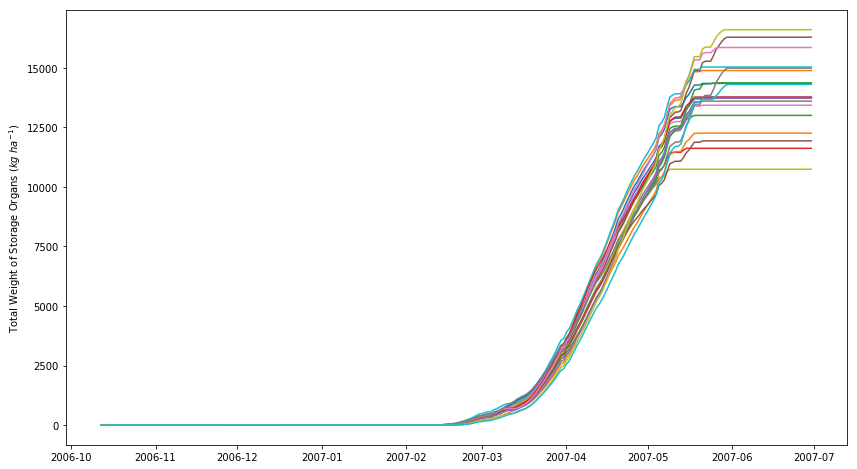

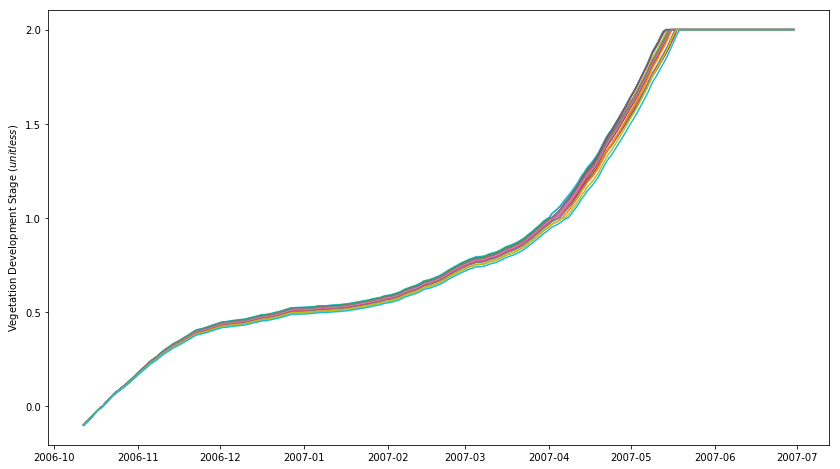

In [7]:
# loop through the parameters
for n,i in enumerate(target_parameters):
    
    # extract the key in the dictionary
    out_param = outputs_1[i]
    
    plt.figure(figsize=(14,8))
    plt.ylabel(ensembles_1._units(i))
    # loop throug the ensembles
    for j in out_param:
        plt.plot(ensembles_1.Time(), j)

In [8]:
# repeat in limied mode:
ensembles_12 = enwofost(ensemble_number,'limited')

ensembles_12.Generate_With_Dists_From_Scratch(distribution_file,crop_file,soil_file,weather_point,timer_file)

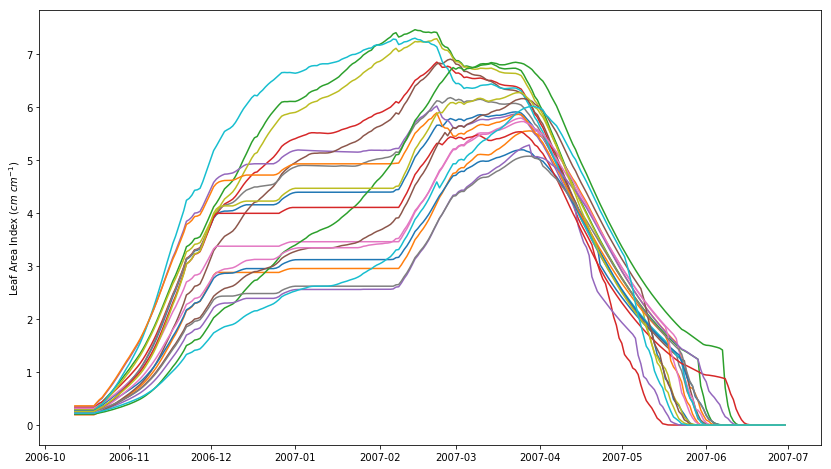

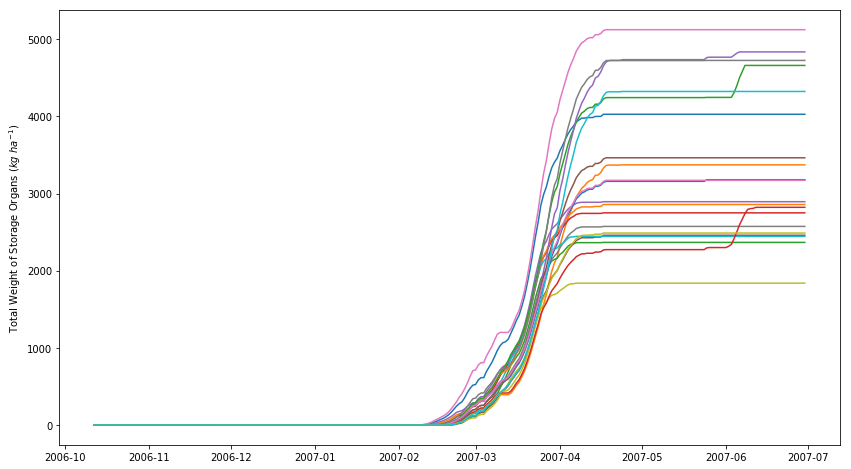

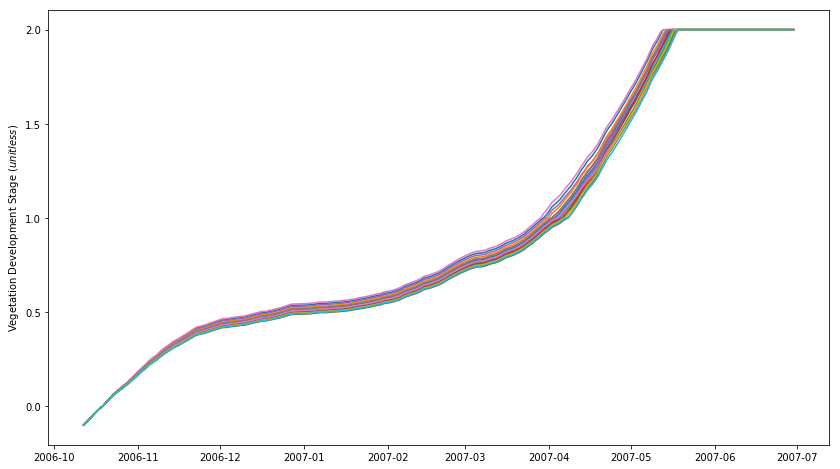

In [9]:
# use the method Extract_Params to get a dictionary of outputs
outputs_12 = ensembles_12.Extract_Params(target_parameters)
# loop through the parameters
for n,i in enumerate(target_parameters):
    
    # extract the key in the dictionary
    out_param = outputs_12[i]
    
    plt.figure(figsize=(14,8))
    plt.ylabel(ensembles_12._units(i))
    # loop throug the ensembles
    for j in out_param:
        plt.plot(ensembles_1.Time(), j)

## Next, run ensembles using established wofost objects:

In [10]:
# first, instantiate the WOFOST objects
crop = CABOFileReader(crop_file)
soil = CABOFileReader(soil_file)
site = WOFOST71SiteDataProvider(WAV=20, SSMAX=0, IFUNRN=0, SSI=0, SMLIM=0.065)

parameters = ParameterProvider(crop,soil,site)

weather = CABOWeatherDataProvider(weather_point)

agromanagement = YAMLAgroManagementReader(timer_file)

In [11]:
# add another campaign starting from a different year

new_start_date = dt.date(2007,10,15)

new_campaign = copy.deepcopy(agromanagement[0][dt.date(2006,10,1)])

# add the new start and end dates
new_campaign['CropCalendar']['crop_start_date'] = new_start_date
new_campaign['CropCalendar']['crop_end_date'] = dt.date(2008,6,15)

# and append it to the agromanager
agromanagement.append({new_start_date: new_campaign})

In [12]:
# ok, now run the ensembles using these new objects
ensembles_2 = enwofost(ensemble_number, 'potential')

ensembles_2.Generate_With_Dists_From_Objects('par_prior.csv',crop,soil,site,weather,agromanagement)

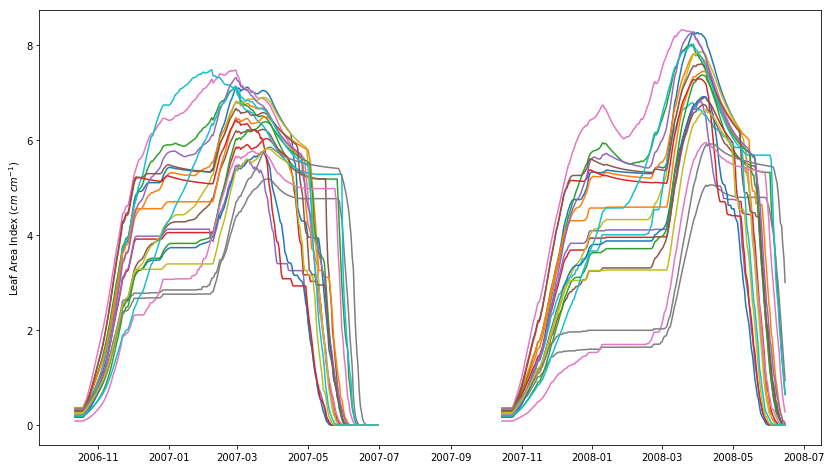

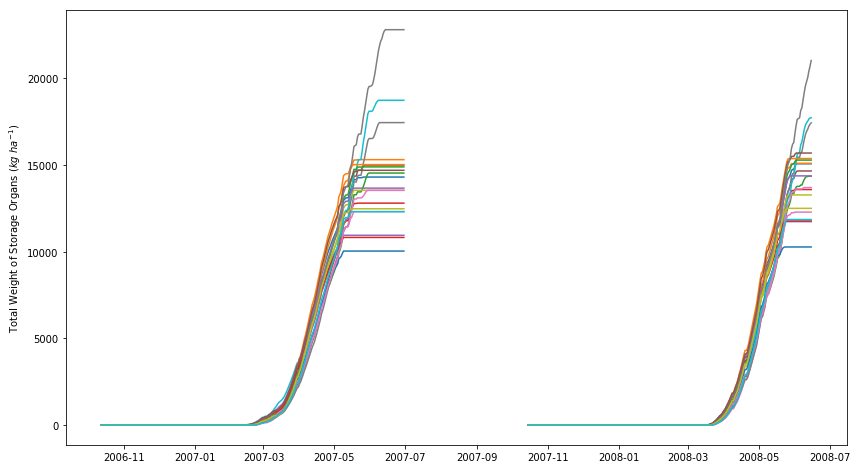

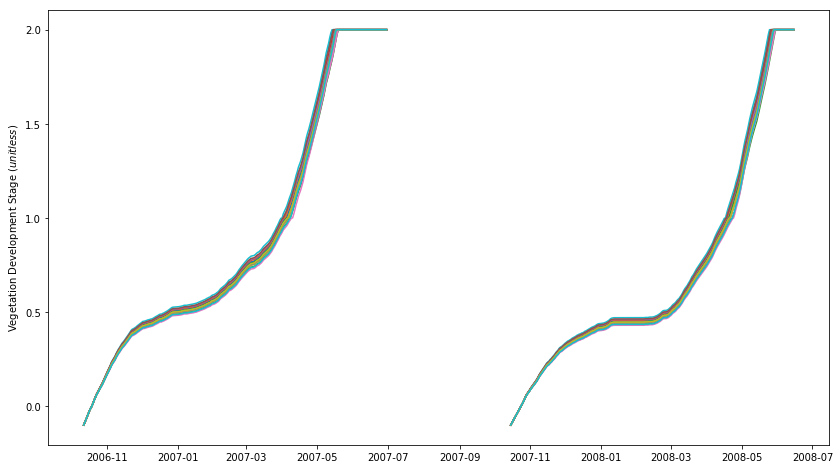

In [13]:
# define some parameters we want to see
target_parameters = ['LAI', 'TWSO', 'DVS']

# use the method Extract_Params to get a dictionary of outputs
outputs_2 = ensembles_2.Extract_Params(target_parameters)

# loop through the parameters
for n,i in enumerate(target_parameters):
    
    # extract the key in the dictionary
    out_param = outputs_2[i]
    
    plt.figure(figsize=(14,8))
    plt.ylabel(ensembles_2._units(i))
    # loop throug the ensembles
    for j in out_param:
        plt.plot(ensembles_2.Time(), j)

## Also try running with the central value of the distributions set to 'relative' mode.

When parameters are being generated, the default is to use the mu from the input csv as the central value in the parameter normal distribtion. Sometimes it may be useful to vary the parameters around the parameters alreaady given in the parameter object. This is usefull for different crops and different localities. 

In [14]:
# try running in relative mode
ensembles_3 = enwofost(ensemble_number, 'potential')

ensembles_3.Generate_With_Dists_From_Objects('par_prior.csv',crop,soil,site,weather,agromanagement,
                                            'relative') # ===== specifiy here 'relative' to do this


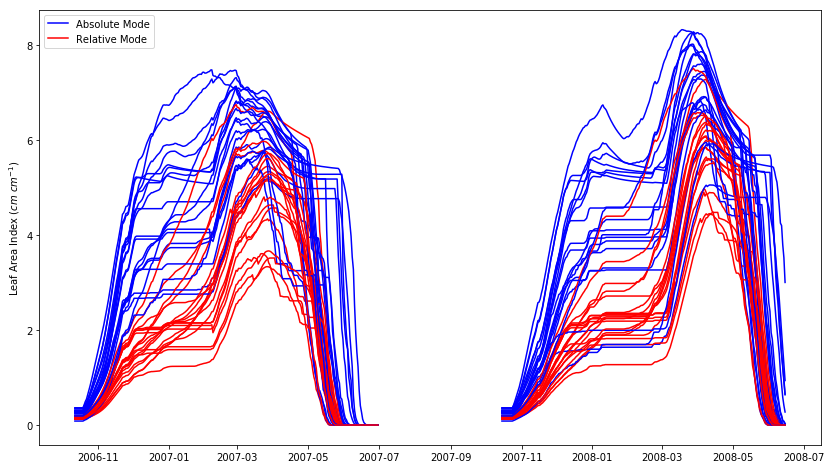

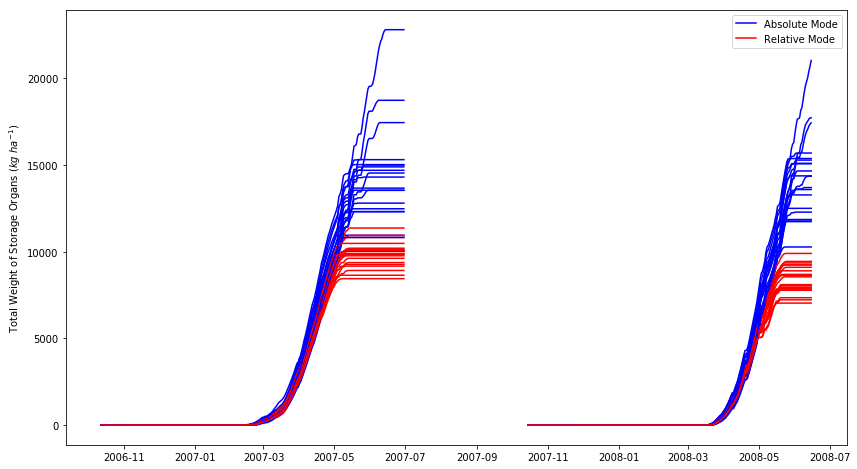

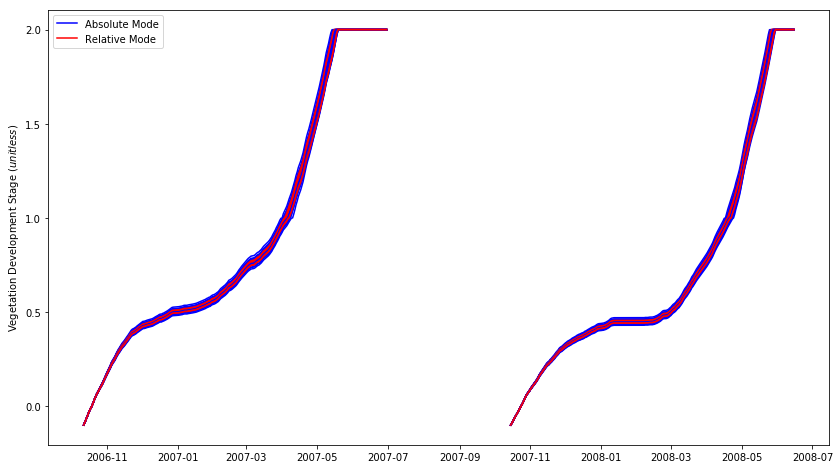

In [15]:
# lets compare the two distributions from absolute and relative mode

# use the method Extract_Params to get a dictionary of outputs
outputs_3 = ensembles_3.Extract_Params(target_parameters)

# loop through the parameters
for n,i in enumerate(target_parameters):
    
    # extract the key in the dictionary
    out_param_abs = outputs_2[i]
    out_param_rel = outputs_3[i]
    
    plt.figure(figsize=(14,8))
    plt.ylabel(ensembles_2._units(i))
    # loop throug the ensembles
    for n2,j in enumerate(out_param_abs):
        plt.plot(ensembles_2.Time(), j, c='b')
        plt.plot(ensembles_3.Time(), out_param_rel[n2], c='r')
        
    plt.plot([], [],c='b', label='Absolute Mode')
    plt.plot([], [], c='r', label='Relative Mode')
    plt.legend()

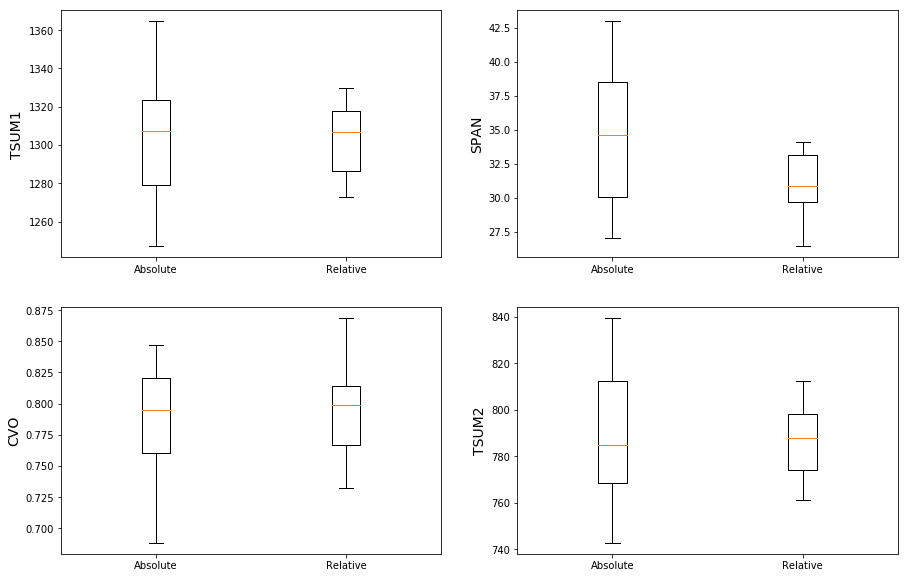

In [16]:
# lets have a look at the parameters that were pulled out of the two different ensembles

# parameters varied for the absolute mode
p_abs = ensembles_2.Get_Input_Values()

# parameters varied for the relative mode
p_rel = ensembles_3.Get_Input_Values()

fig,axs = plt.subplots(2,2,figsize=(15,10))
axs = np.ravel(axs)

for n,i in enumerate(['TSUM1', 'SPAN', 'CVO', 'TSUM2']):
    
    dist1 = p_abs[i]
    dist2 = p_rel[i]
        
    axs[n].boxplot([dist1,dist2], positions=[1,2])
    axs[n].set_xticks([1,2])
    axs[n].set_xticklabels(['Absolute', 'Relative'])
    axs[n].set_ylabel(i,fontsize=14)

## Try creating the ensembles but also varying the planting date as well as the parameters

In [17]:
# point the parameter distribution at the one with the 'PDATE' is varied
ensembles_4 = enwofost(ensemble_number, 'potential')

ensembles_4.Generate_With_Dists_From_Objects('par_prior_with_pdate.csv',crop,soil,site,weather,agromanagement,
                                            'relative')

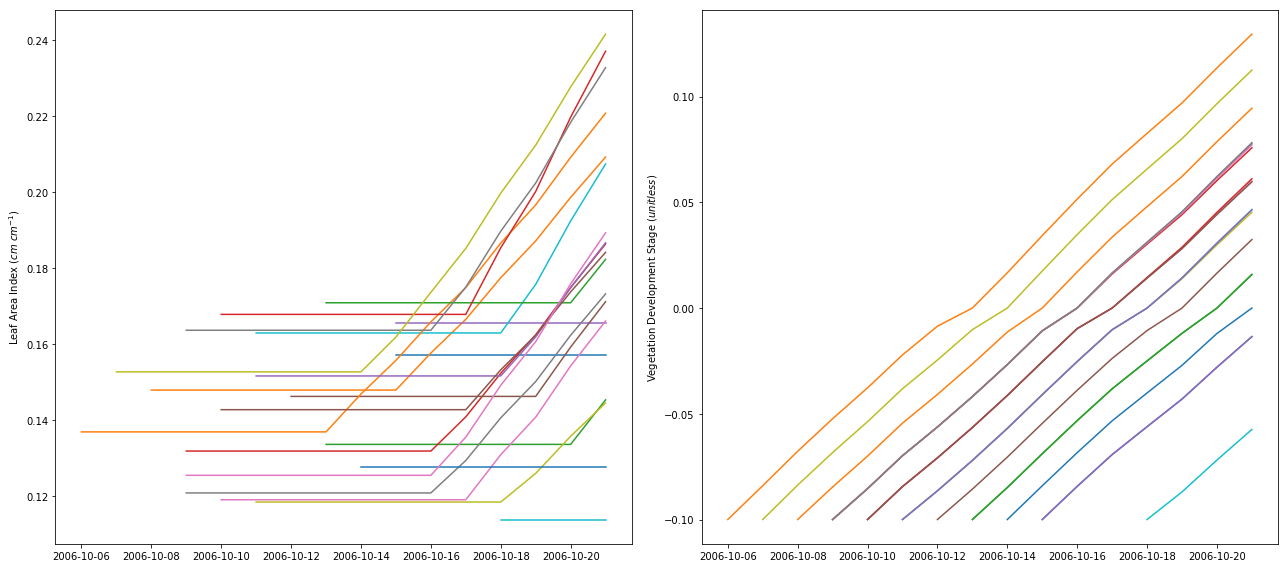

In [24]:
# show how the first month has variable starting dates
display_params = ['LAI','DVS']
ens4_outputs = ensembles_4.Extract_Params(display_params)

fig,axs = plt.subplots(1,2,figsize=(18,8))
axs = np.ravel(axs)

time = ensembles_4.Time()

for n,i in enumerate(display_params):
    for j in ens4_outputs[i]:
        axs[n].plot(time[:40],j[:40])
        
    axs[n].set_ylabel(ensembles_4._units(i))
        
plt.tight_layout()

## We can use the PDF_Image method to display the probability distribution function for the ensemble space

This creates an image that finds the distribution of the ensembles at each day, and creates a 2d image at the sub day resolution.
<br/>(Note - the image is capped below it's maximum value to prevent the image from being washed out)

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/acornelius/enwofost/git_repo/wofost_tools/enwofost.py:628: RuntimeWarning: invalid value encountered in double_scalars
  vertical, (lower_l - mu_l) / sigma_l, (upper_l - mu_l)\
/home/acornelius/enwofost/git_repo/wofost_tools/enwofost.py:629: RuntimeWarning: invalid value encountered in double_scalars
  / sigma_l,loc=mu_l,scale=sigma_l)
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/acornelius/enwofost/git_r

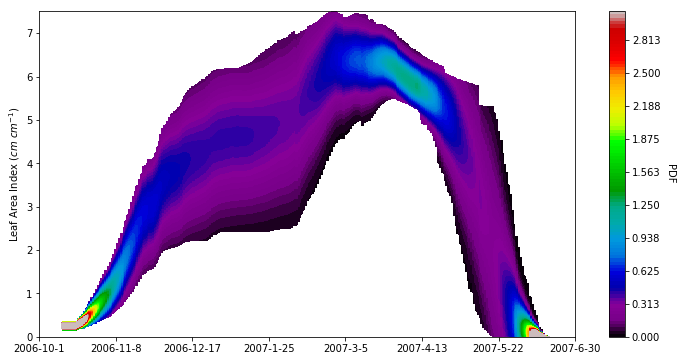

In [14]:
ensembles_1.PDF_Image('LAI')

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/acornelius/enwofost/git_repo/wofost_tools/enwofost.py:632: RuntimeWarning: invalid value encountered in double_scalars
  vertical, (lower_u - mu_u) / sigma_u, (upper_u - mu_u)\
/home/acornelius/enwofost/git_repo/wofost_tools/enwofost.py:633: RuntimeWarning: invalid value encountered in double_scalars
  / sigma_u,loc=mu_u,scale=sigma_u)
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/acornelius/enwofost/git_r

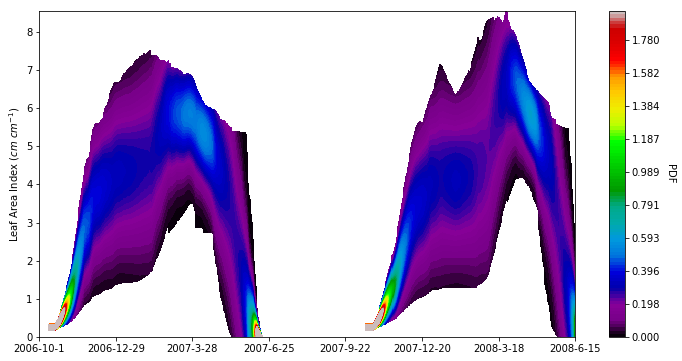

In [15]:
ensembles_2.PDF_Image('LAI')

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/acornelius/enwofost/git_repo/wofost_tools/enwofost.py:661: RuntimeWarning: invalid value encountered in greater
  capped = np.where(im_cap > max_val)


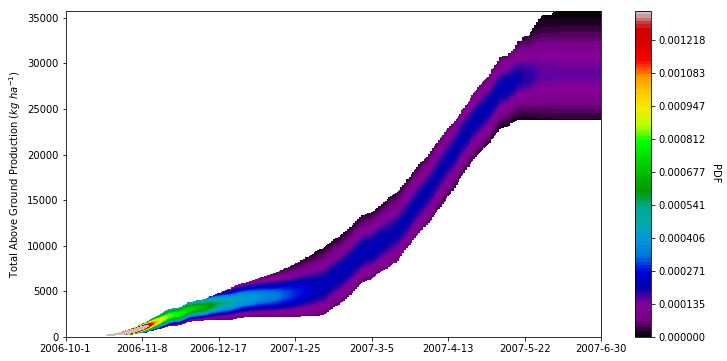

In [16]:
ensembles_1.PDF_Image('TAGP')